In [1]:
from classes.Point import *
from pyproj import Proj
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

### Load data

In [2]:
settlements = pd.concat(
    map(
        pd.read_csv,
        [
            'datasets/towns.csv',
            'datasets/cities.csv',
            'datasets/villages.csv'
        ]
    ),
    ignore_index = True
)

### Modify data

In [3]:
# Rename callret-3 column to population
settlements.rename(
    columns = { 'callret-3': 'population' },
    inplace = True
)

### Extend data

In [4]:
# Calculate radii of settlements
settlements['radius'] = settlements.apply(
    lambda row:
        math.sqrt(
            row['area'] / math.pi
        ),
    axis = 1
)

In [5]:
# Calculate densities of settlements
settlements['density'] = settlements.apply(
    lambda row:
        row['population'] / (row['area'] / 1000000),
    axis = 1
)

### Transform data

In [6]:
# Convert geographic settlements coords to x, y coords
projection = Proj(
    proj = 'utm',
    zone = 34,
    ellps = 'WGS84',
    preserve_units = False
)
x, y = projection(
    tuple(settlements.long),
    tuple(settlements.lat)
)
xs, ys = list(x), list(y)
xmin, ymin = min(xs), min(ys)
settlements['x'] = [ x - xmin for x in xs ]
settlements['y'] = [ y - ymin for y in ys ]

In [7]:
settlements.head()

,name,long,lat,population,area,radius,density,x,y
0,Barcs,17.4601,45.9601,10667,122900000.0,6254.621093,86.794142,94551.686596,22476.155936
1,Battonya,21.0167,46.2833,5960,145770000.0,6811.756903,40.886328,370132.118200,52291.852872
2,Beled,17.0968,47.4661,2686,26470000.0,2902.699207,101.473366,74712.467194,191117.163196
3,Belvárdgyula,18.4333,45.9667,397,17230000.0,2341.896526,23.041207,169983.061933,20317.899726
4,Budakalász,19.0460,47.6215,10660,15170000.0,2197.444191,702.702703,222025.590806,202849.524978


### Plot settlements

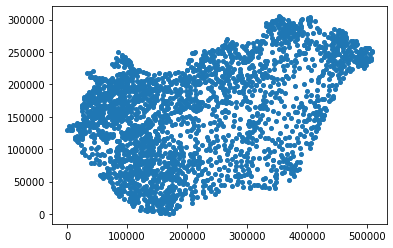

In [8]:
plt.plot(settlements.x, settlements.y, 'o', markersize = 4)
plt.show()

In [9]:
# VARIABLE
fraction_of_population = 0.0001
initial_infection_probability = 0.01

def random_status():
    return True if random.random() < initial_infection_probability else False

def generatePeople(settlements):
    people = []
    for s in settlements:
        # settlement(name, long, lat, population, area, radius, density, x, y)
        settlement_name, center, radius, population = s[0], Point(s[7], s[8]), s[5], s[3]
        for _ in range(round(population*fraction_of_population)):
            position = Point.randomPoint(radius, center)
            covid_status = random_status()
            if covid_status is True:
                days_since_infection = 0
            else:
                days_since_infection = 100
#             if settlement_name == "Budapest":
#                 covid_status = True
#             else:
#                 covid_status = False
            people.append([settlement_name, position.x, position.y, covid_status, days_since_infection])
    return people

people = pd.DataFrame(generatePeople(settlements.values), columns = ['city_name', 'x', 'y', 'infected', 'days_since_inf'])
people.head()

,city_name,x,y,infected,days_since_inf
0,Barcs,92371.793129,17623.714194,False,100
1,Battonya,374324.698133,49944.978346,False,100
2,Budakalász,221307.722473,204712.810762,False,100
3,Budakeszi,211438.952783,190139.165654,False,100
4,Budaörs,214844.265354,185156.207523,False,100


From the population of 718 (grey), 7 person is infected (red).


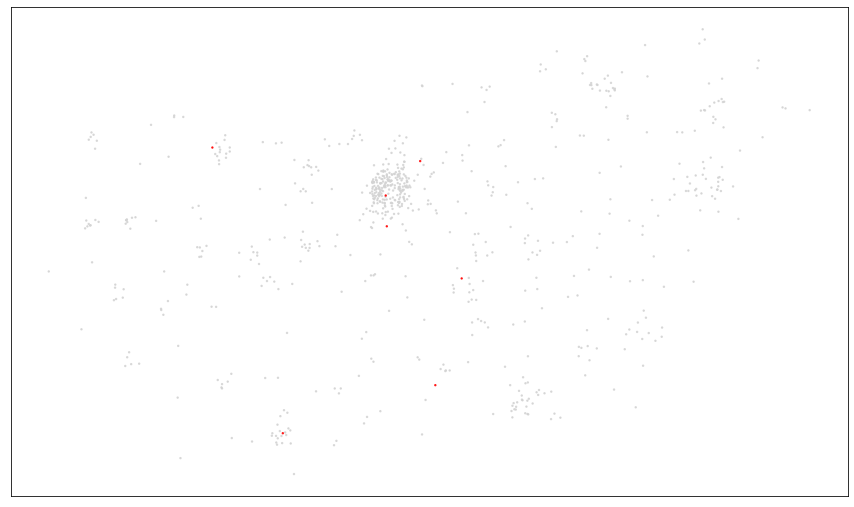

In [10]:
print("From the population of {} (grey), {} person is infected (red).".format(len(people),people.infected.sum()))

plt.figure(figsize=(15, 9))
plt.scatter(people.x, people.y, c=people.infected, cmap=ListedColormap(["lightgrey", "red"]), s=2, alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.show()

# Move people



In [11]:
settlements_dict = settlements[["name", "population"]].values
settlements_dict[:, 1] /= sum(settlements_dict[:, 1])

# generating city moving probability distribution
city_names, city_probs  = list(settlements_dict[:, 0]), list(settlements_dict[:, 1])

In [12]:
def generate_city():
    global city_names, city_probs
    return np.random.choice(city_names, 1, p=city_probs)[0]

def change_position(city_name):
    global settlements
    # get the row belonging to the city_name from the settlements dataframe
    row = settlements.loc[settlements["name"] == city_name]
    # get radius, x, y values from row
    radius, x, y = row[['radius', 'x', 'y']].values[0]
    center = Point(x, y)
    position = Point.randomPoint(radius, center)
    return pd.Series([position.x, position.y], index =['x', 'y'])

# TODO: too long after move city, join the two datasets (people, settlements), and fill x, y and radius columns

people.head()

,city_name,x,y,infected,days_since_inf
0,Barcs,92371.793129,17623.714194,False,100
1,Battonya,374324.698133,49944.978346,False,100
2,Budakalász,221307.722473,204712.810762,False,100
3,Budakeszi,211438.952783,190139.165654,False,100
4,Budaörs,214844.265354,185156.207523,False,100


In [13]:
nr_of_infected_people = people.loc[people['infected'] == True].size
print(f'Infection ratio: {people.infected.sum()}/{len(people)} ({people.infected.sum()/len(people)})')

Infection ratio: 7/718 (0.009749303621169917)


In [14]:
%%time

#################
# VARIABLES
#################
simulated_days = 365
# 10% move between cities, 20% move inside city
intercity_move_prob = 0.1
intracity_move_prob = 0.2
infection_probability = 0.1
infection_length = 14 
immunity_lenght = 60
#################

people_frames = [people.copy(deep=True)]
number_of_infected = [people.infected.sum()]

# move probability
move_prob = intercity_move_prob + intracity_move_prob
# number of people to move
move_num = round(people.shape[0] * move_prob)
# index to cut moving people (inside & outsite settlement)
cut = round(intercity_move_prob / move_prob * move_num)

for day in range(simulated_days):

    # random people to move
    moving = people.sample(move_num)
 
    # to another settlement
    out_city = moving[:cut]
    for i in range(len(out_city)):
        out_city['city_name'].values[i] = generate_city()
    
    # inside the settlement (and move those changing cities to not be outside city boundary)
    in_city = moving
    for i in range(len(in_city)):
        in_city['x'].values[i], in_city['y'].values[i] = change_position(in_city['city_name'].values[i])

    people.update(moving)


    # FERTŐZÉS
    infected_people = moving.loc[people['infected'] == True]

    for person in infected_people.values:
        city = person[0]
        #immunity
        # people_to_infect = people.loc[(people['city_name'] == city) & (people['infected'] == False)]
        people_to_infect = people.loc[(people['city_name'] == city) & (people['infected'] == False) & (people['days_since_inf'] > immunity_lenght)]

        for j in range(len(people_to_infect)):
            infect_decision = True if random.random() < infection_probability else False
            if infect_decision is True:
                people_to_infect['infected'].values[j] = True
                people_to_infect['days_since_inf'].values[j] = 0

        people.update(people_to_infect)
    people['days_since_inf'] = people['days_since_inf'].add(1)
    people_frames.append(people.copy())
    number_of_infected.append(people.infected.sum())
    
    # healing
    people.loc[people["days_since_inf"] > infection_length, "infected"] = False
    
    print("Infection ratio day #{}: {}/{} ({})".format(day, people.infected.sum(), len(people), round(people.infected.sum()/len(people),3)))

Infection ratio day #0: 27/718 (0.038)
Infection ratio day #1: 88/718 (0.123)
Infection ratio day #2: 170/718 (0.237)
Infection ratio day #3: 207/718 (0.288)
Infection ratio day #4: 221/718 (0.308)
Infection ratio day #5: 241/718 (0.336)
Infection ratio day #6: 269/718 (0.375)
Infection ratio day #7: 287/718 (0.4)
Infection ratio day #8: 305/718 (0.425)
Infection ratio day #9: 323/718 (0.45)
Infection ratio day #10: 342/718 (0.476)
Infection ratio day #11: 364/718 (0.507)
Infection ratio day #12: 379/718 (0.528)
Infection ratio day #13: 391/718 (0.545)
Infection ratio day #14: 383/718 (0.533)
Infection ratio day #15: 337/718 (0.469)
Infection ratio day #16: 268/718 (0.373)
Infection ratio day #17: 238/718 (0.331)
Infection ratio day #18: 237/718 (0.33)
Infection ratio day #19: 230/718 (0.32)
Infection ratio day #20: 209/718 (0.291)
Infection ratio day #21: 199/718 (0.277)
Infection ratio day #22: 193/718 (0.269)
Infection ratio day #23: 182/718 (0.253)
Infection ratio day #24: 165/718 

Infection ratio day #201: 98/718 (0.136)
Infection ratio day #202: 101/718 (0.141)
Infection ratio day #203: 109/718 (0.152)
Infection ratio day #204: 109/718 (0.152)
Infection ratio day #205: 106/718 (0.148)
Infection ratio day #206: 118/718 (0.164)
Infection ratio day #207: 112/718 (0.156)
Infection ratio day #208: 114/718 (0.159)
Infection ratio day #209: 116/718 (0.162)
Infection ratio day #210: 114/718 (0.159)
Infection ratio day #211: 112/718 (0.156)
Infection ratio day #212: 106/718 (0.148)
Infection ratio day #213: 108/718 (0.15)
Infection ratio day #214: 110/718 (0.153)
Infection ratio day #215: 115/718 (0.16)
Infection ratio day #216: 122/718 (0.17)
Infection ratio day #217: 126/718 (0.175)
Infection ratio day #218: 128/718 (0.178)
Infection ratio day #219: 126/718 (0.175)
Infection ratio day #220: 125/718 (0.174)
Infection ratio day #221: 128/718 (0.178)
Infection ratio day #222: 120/718 (0.167)
Infection ratio day #223: 119/718 (0.166)
Infection ratio day #224: 123/718 (0.1

In [15]:
people.head(10)

,city_name,x,y,infected,days_since_inf
0,Budapest,222496.754743,197164.296375,False,49.0
1,Gyula,393753.056736,86116.109443,False,33.0
2,Cegléd,281388.530313,147078.957301,False,25.0
3,Budapest,226101.469260,180314.397492,True,7.0
4,Sándorfalva,296554.419031,62018.834274,False,46.0
5,Budapest,222395.616359,182575.389719,True,12.0
6,Pogány,154998.880004,21641.191787,False,64.0
7,Bakonszeg,400158.679834,151253.506429,False,92.0
8,Hernád,246299.822345,153019.523585,False,61.0
9,Kapuvár,72282.173193,204429.341418,False,36.0


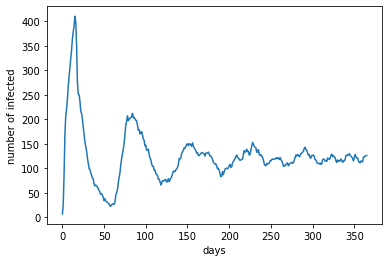

In [16]:
plt.plot(list(range(len(number_of_infected))), number_of_infected)
plt.xlabel("days")
plt.ylabel("number of infected")
plt.show()


# Animated plot

In [17]:
# Enable interactive plot
%matplotlib notebook

<IPython.core.display.Javascript object>


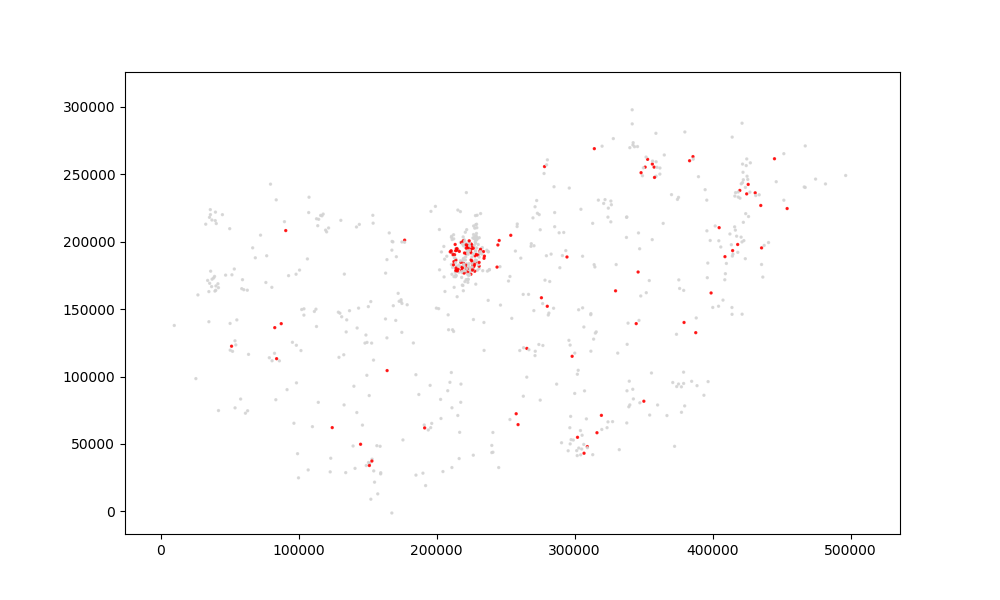

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_xlim(0, 520000), ax.set_xticks([])
ax.set_ylim(0, 310000), ax.set_yticks([])

# TODO: animation draws figures on top of each other, clear the older frames somehow
plot = plt.scatter([], [], c=[], cmap=ListedColormap(["lightgrey", "red"]), s=2, alpha=0.8)


def updatefig(*args):
    global people_frames
    fig.clear()
    plot = plt.scatter([people_frames[args[0]].x], people_frames[args[0]].y, c=people_frames[args[0]].infected, cmap=ListedColormap(["lightgrey", "red"]), s=2, alpha=0.8)
    plt.scatter([0, 510000], [0, 310000], s = 1, c = "white")
    return plot,

ani = FuncAnimation(fig, updatefig, frames=simulated_days, interval=1000/24, repeat=False)
plt.show()